In [32]:
#LIMPIEZA Y MANIPULACION DE DATOS
import pandas as pd
import re
from unidecode import unidecode
import numpy as np

#FUNCIONES
from funciones_usisa_segmentacion_clientes import *

#VISUALIZACION
import seaborn as sns
import matplotlib.pyplot as plt

#MAPAS
import folium
from geopy.geocoders import Nominatim


#PREPROCESAMIENTO
from sklearn.preprocessing import StandardScaler

#MODELOS
from sklearn.cluster import KMeans
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# LIMPIEZA Y MANIPULACIÓN DE DATOS

#### CARGAR DATA NUEVO

In [33]:
pd.set_option("display.max_columns", None)

In [34]:
df_nuevo = pd.read_csv("tienda_online_nuevo.csv")

#### EDITAR DF_NUEVO

In [35]:
df_nuevo = todas_las_funciones_nuevo(df_nuevo)

#### CREAR DF_CLIENTE

In [36]:
df_cliente = crear_df_cliente(df_nuevo)

# EDA DF_CLIENTE

In [37]:
columnas_modelo = ['dias_desde_la_ultima_compra', 'numero_de_pedidos_por_cliente', 'facturacion_total_por_cliente(€)']
colors = ['royalblue', 'deeppink', 'forestgreen']

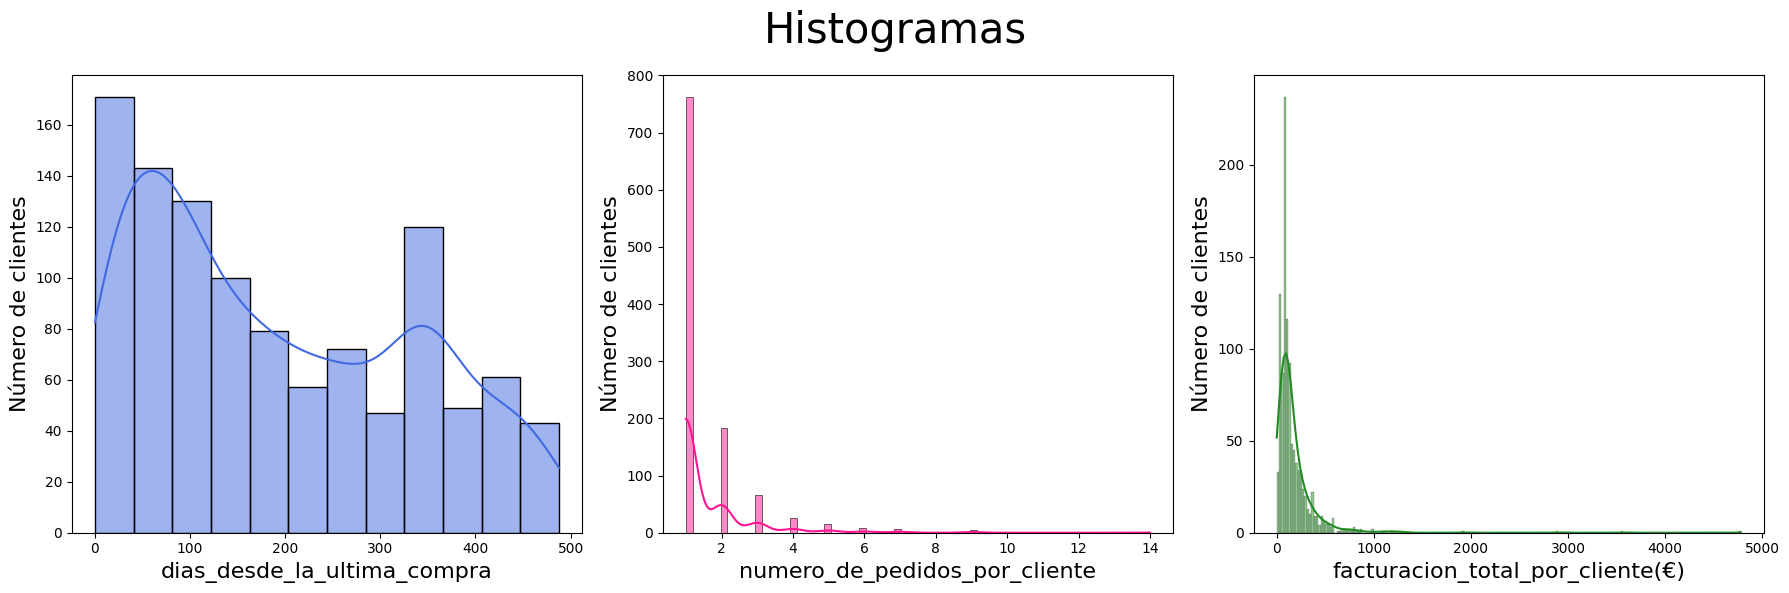

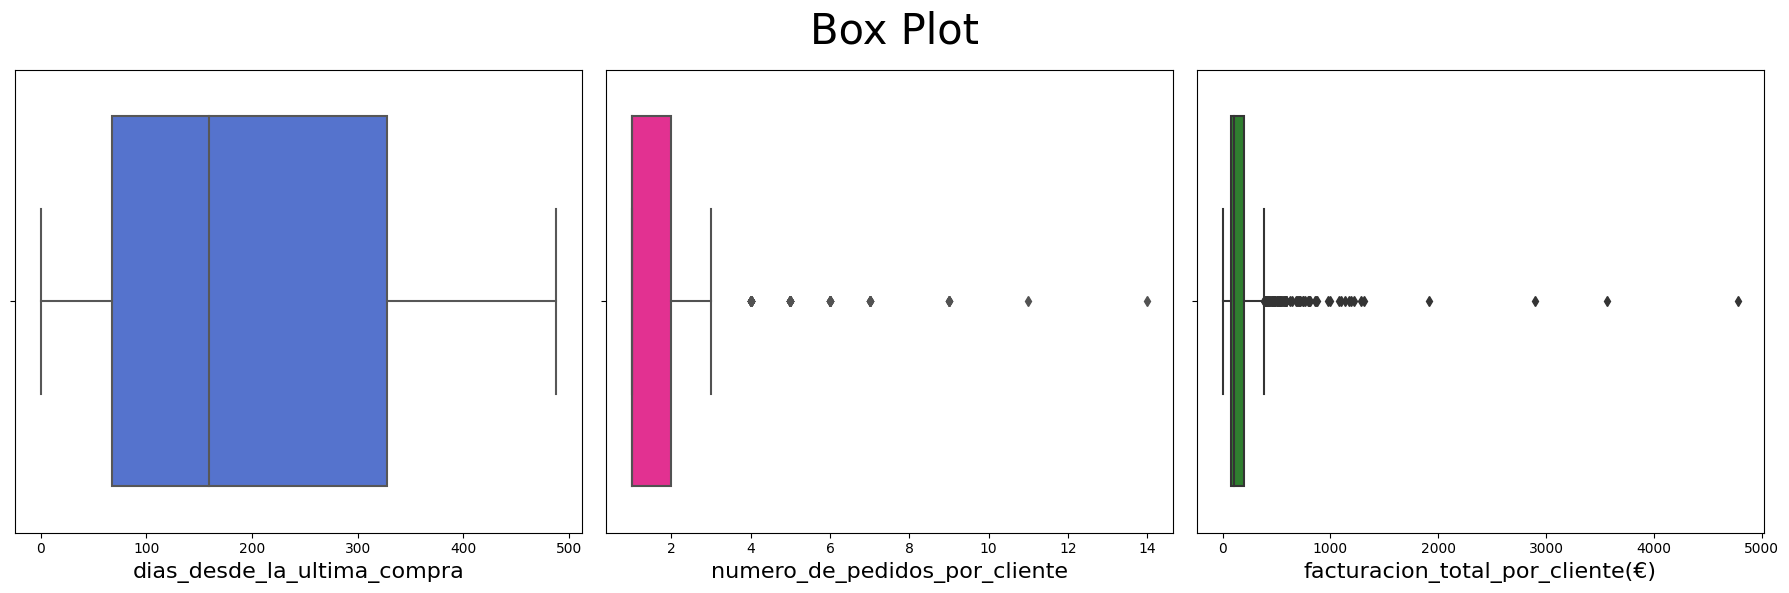

In [38]:
plot_histograms_and_boxplots(df_cliente, columnas_modelo, colors)

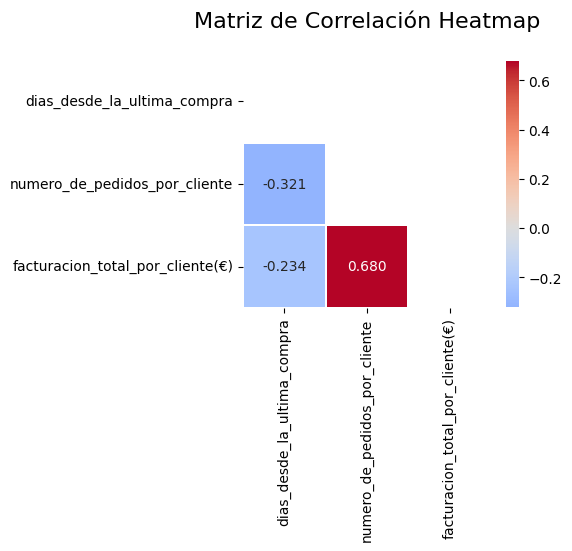

In [39]:
plot_heatmap(df_cliente, columnas_modelo)

#### MAPA GEOLOCALIZACIÓN DE PEDIDOS POR CÓDIGO POSTAL

In [40]:
df_mapa=df_cliente[["numero_de_pedidos_por_cliente", "billing_postcode"]].copy()
df_mapa_unicos=df_mapa.groupby("billing_postcode")["numero_de_pedidos_por_cliente"].sum().reset_index()
dicc_mapa=dict(zip(df_mapa_unicos["billing_postcode"], df_mapa_unicos["numero_de_pedidos_por_cliente"]))

In [13]:
crear_mapa(dicc_mapa, "orange")

# PREPROCESAMIENTO DE DATOS

#### NORMALIZACIÓN DF_CLIENTE

In [41]:
#NORMALIZACION
df_cliente_log = np.log(df_cliente[columnas_modelo] + 1)

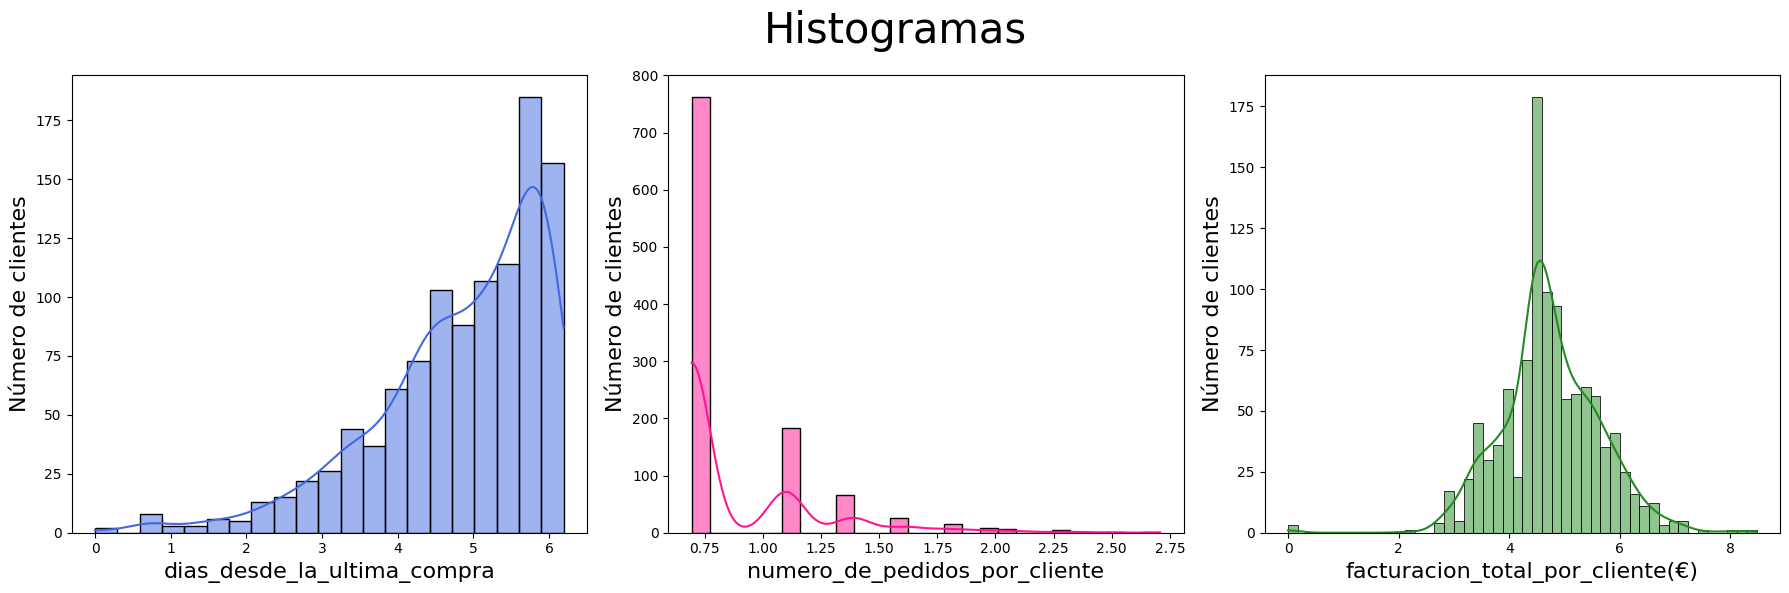

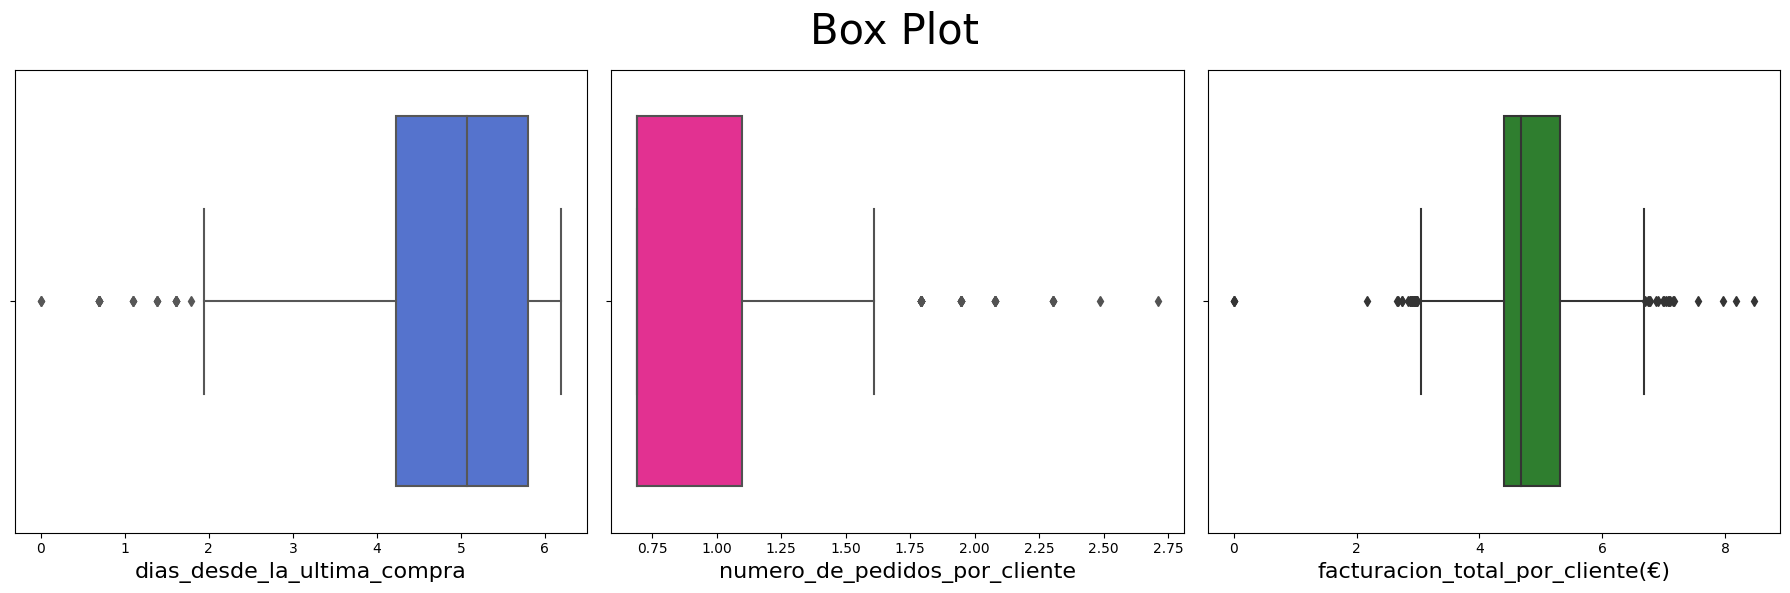

In [42]:
#EDA DESPUES DE NORMALIZACION
plot_histograms_and_boxplots(df_cliente_log, columnas_modelo, colors)

#### ESCALADO DF_CLIENTE_LOG

In [43]:
#ESCALADO
st_sc = StandardScaler()
scaled_features=st_sc.fit_transform(df_cliente_log)

# CLUSTER DE CLIENTES POR COMPORTAMIENTO DEL CONSUMIDOR

#### K-MEANS

In [44]:
def calculate_wcss(data, max_k):
    wcss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

In [45]:
max_k = 10
wcss_values = calculate_wcss(scaled_features, max_k)

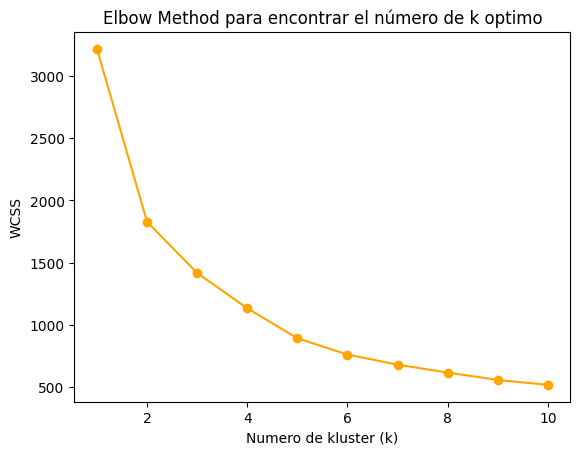

In [46]:
plt.plot(range(1, max_k + 1), wcss_values, marker='o', color='orange')
plt.xlabel('Numero de kluster (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method para encontrar el número de k optimo')
plt.show()

In [47]:
#KMEANS
optimal_k = 3 

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
df_cliente_log['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

#### DBSCAN

In [48]:
#ENCONTRAR LOS PARÁMETROS IDEALES PARA DBSCAN

param_grid = {
    'eps': [0.1, 0.5, 1.0, 1.5],
    'min_samples': [3, 5, 10, 15]
}

silhouette_scores = []

for params in ParameterGrid(param_grid):
    dbscan_pa = DBSCAN(**params)
    labels = dbscan_pa.fit_predict(scaled_features)  

    silhouette = silhouette_score(scaled_features, labels) 

    silhouette_scores.append({'params': params, 'silhouette': silhouette})

best_params = max(silhouette_scores, key=lambda x: x['silhouette'])['params']

best_dbscan = DBSCAN(**best_params)
labels_best = best_dbscan.fit_predict(scaled_features)  
print(f"Mejor DBSCAN Parametros: {best_params}")
print(f"Mejor Silhouette Score: {max(silhouette_scores, key=lambda x: x['silhouette'])['silhouette']}")

Mejor DBSCAN Parametros: {'eps': 1.5, 'min_samples': 5}
Mejor Silhouette Score: 0.6460468381482933


In [49]:
#MODELO DBSCAN
dbscan_cliente = DBSCAN(eps=1, min_samples=10)
df_cliente_log['DBSCAN_Cluster'] = dbscan_cliente.fit_predict(scaled_features)
df_cliente_log['DBSCAN_Cluster'] = df_cliente_log['DBSCAN_Cluster'].replace({-1: 0, 0: 1, 1: 2})
num_clusters = len(set(df_cliente_log['DBSCAN_Cluster'])) - (1 if -1 in df_cliente_log['DBSCAN_Cluster'] else 0)
print(f"Número de clusters: {num_clusters}")

Número de clusters: 3


#### K-MEANS VS DBSCAN

In [50]:
# KMeans
kmeans_cluster_labels = df_cliente_log['KMeans_Cluster']
silhouette_kmeans = silhouette_score(scaled_features, kmeans_cluster_labels)
db_kmeans = davies_bouldin_score(scaled_features, kmeans_cluster_labels)
ch_kmeans = calinski_harabasz_score(scaled_features, kmeans_cluster_labels)

# DBSCAN
dbscan_cluster_labels = df_cliente_log['DBSCAN_Cluster']
silhouette_dbscan = silhouette_score(scaled_features, dbscan_cluster_labels)
db_dbscan = davies_bouldin_score(scaled_features, dbscan_cluster_labels)
ch_dbscan = calinski_harabasz_score(scaled_features, dbscan_cluster_labels)

# Imprimir resultados
print("Resultados para KMeans:")
print(f"Silhouette Score: {silhouette_kmeans}")
print(f"Davies-Bouldin Index: {db_kmeans}")
print(f"Calinski-Harabasz Index: {ch_kmeans}")

print("\nResultados para DBSCAN:")
print(f"Silhouette Score: {silhouette_dbscan}")
print(f"Davies-Bouldin Index: {db_dbscan}")
print(f"Calinski-Harabasz Index: {ch_dbscan}")

Resultados para KMeans:
Silhouette Score: 0.36896105576385757
Davies-Bouldin Index: 0.9960682219550829
Calinski-Harabasz Index: 678.8144860861654

Resultados para DBSCAN:
Silhouette Score: 0.4316345316143165
Davies-Bouldin Index: 2.2407925340096853
Calinski-Harabasz Index: 381.47632412633425


#### SELECCIONAMOS K-MEANS Y USAMOS OTROS MODELOS PARA ANALIZAR COMO DE EFICIENTE ES K-MEANS ASIGNANDO CLUSTERS

In [51]:
X = df_cliente_log[columnas_modelo]
Y = df_cliente_log['KMeans_Cluster']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_test = rf.predict(X_test)
accuracy_score(Y_test, y_pred_test)

0.9906832298136646

In [53]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
y_pred_test_lr = lr.predict(X_test)
accuracy_score(Y_test, y_pred_test_lr)

0.9751552795031055

In [54]:
xgb=XGBClassifier()
xgb.fit(X_train, Y_train)
y_pred_test_xgb = xgb.predict(X_test)
accuracy_score(Y_test, y_pred_test_xgb)

0.9906832298136646

# GRÁFICOS CLUSTERS

#### K-MEANS CLUSTERS SCATTER PLOT 3D 

In [55]:
#DEFINIMOS COLORES PARA CADA CLUSTER
cluster_colors = {0: 'green', 1: 'blue', 2: 'red'}

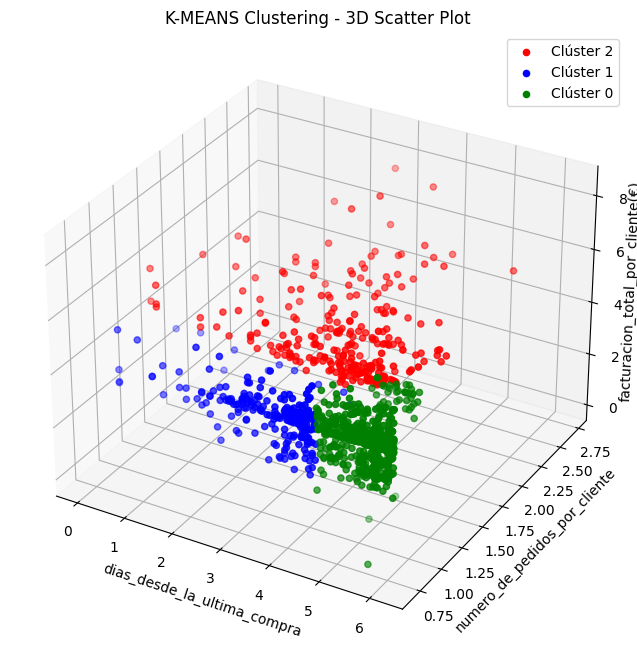

In [56]:
scatter_plot_clusters_3d(df_cliente_log, columnas_modelo, 'KMeans_Cluster', cluster_colors)

#### RADAR GRAPH K-MEANS CLUSTERS 

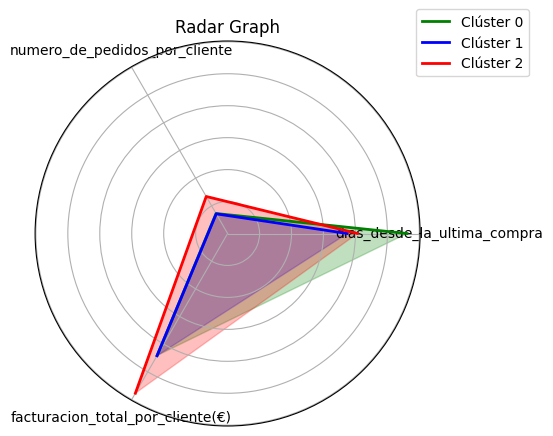

In [57]:
radar_clusters(df_cliente_log, 'KMeans_Cluster', cluster_colors)

#### PIE CHART PROPORCION TOTAL POR CLUSTER

In [58]:
df_cliente['KMeans_Cluster']=df_cliente_log['KMeans_Cluster']

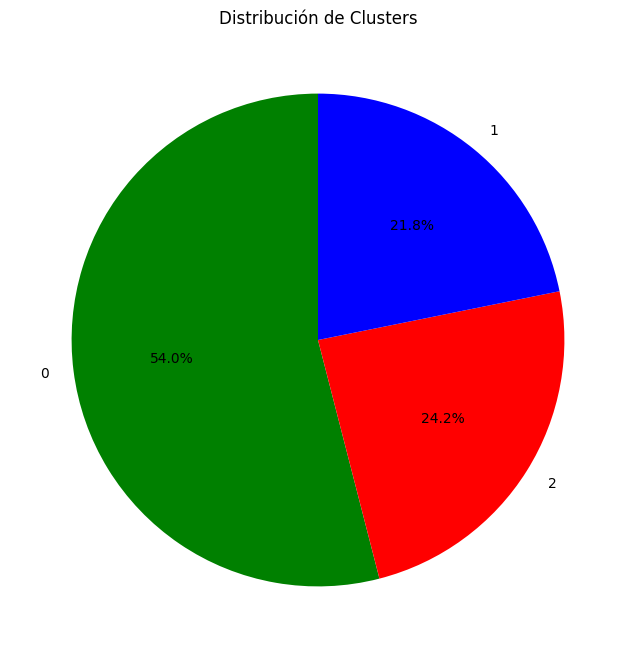

In [59]:
pie_chart_clusters(df_cliente['KMeans_Cluster'].value_counts(), cluster_colors)

#### BAR PLOT FACTURACION TOTAL POR CLUSTER

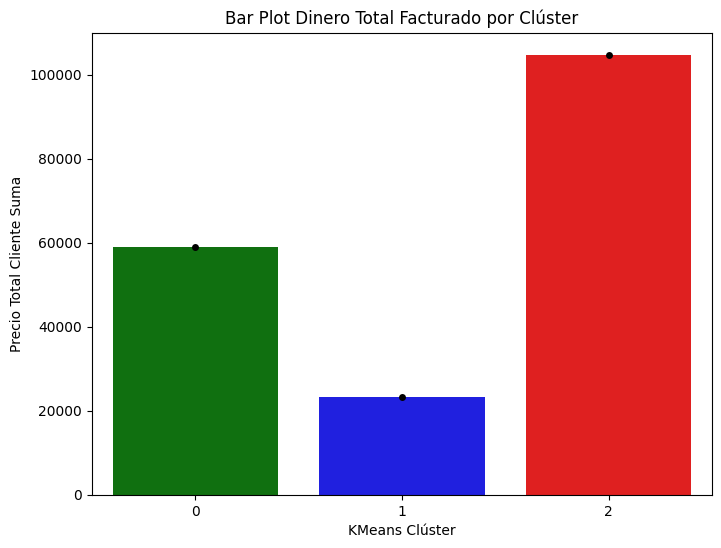

In [60]:
bar_plot_facturacion_totales_clusters(df_cliente, 'KMeans_Cluster', cluster_colors)

In [61]:
#CENTRO DE CADA CLUSTER CON LA MEDIA PARA EXPLICAR CADA GRUPO DE CLIENTES
graficar_centro=df_cliente.groupby('KMeans_Cluster')[columnas_modelo].agg(np.mean)
graficar_centro

,dias_desde_la_ultima_compra,numero_de_pedidos_por_cliente,facturacion_total_por_cliente(€)
KMeans_Cluster,,,
0,294.402418,1.072539,102.026598
1,54.380342,1.042735,99.544316
2,90.930502,3.042471,404.593629


#### MAPAS DE GEOLOCALIZACIÓN POR CODIGO POSTAL

In [35]:
df_mapa=df_cliente[['numero_de_pedidos_por_cliente', 'billing_postcode', 'KMeans_Cluster']].copy()
df_mapa_unicos=df_mapa.groupby('billing_postcode')['numero_de_pedidos_por_cliente'].sum().reset_index()

In [36]:
df_mapa_cluster=df_mapa.groupby('billing_postcode').agg({'numero_de_pedidos_por_cliente': 'sum', 'KMeans_Cluster': 'first'}).reset_index()
df_mapa_cluster_0=df_mapa_cluster.query('KMeans_Cluster==0')
df_mapa_cluster_1=df_mapa_cluster.query('KMeans_Cluster==1')
df_mapa_cluster_2=df_mapa_cluster.query('KMeans_Cluster==2')

In [37]:
dicc_mapa_cluster_0=dict(zip(df_mapa_cluster_0['billing_postcode'], df_mapa_cluster_0['numero_de_pedidos_por_cliente']))
dicc_mapa_cluster_1=dict(zip(df_mapa_cluster_1['billing_postcode'], df_mapa_cluster_1['numero_de_pedidos_por_cliente']))
dicc_mapa_cluster_2=dict(zip(df_mapa_cluster_2['billing_postcode'], df_mapa_cluster_2['numero_de_pedidos_por_cliente']))

##### MAPA GEOLOCALIZACIÓN POR CODIGO POSTAL - CLUSTER 0

In [38]:
crear_mapa(dicc_mapa_cluster_0, 'green')

##### MAPA GEOLOCALIZACIÓN POR CODIGO POSTAL - CLUSTER 1

In [39]:
crear_mapa(dicc_mapa_cluster_1, 'blue')

##### MAPA GEOLOCALIZACIÓN POR CODIGO POSTAL - CLUSTER 2

In [40]:
crear_mapa(dicc_mapa_cluster_2, 'red')